In [1]:
import numpy as np
import json
import pandas as pd
import os
import matplotlib.pyplot as plt
import umap
import math
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
from matplotlib import colors
import matplotlib.transforms as mtrans
import yaml
from yaml.loader import SafeLoader
from collections import OrderedDict
from scipy.ndimage.measurements import center_of_mass
#from verstack.stratified_continuous_split import scsplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import auc, roc_curve, roc_auc_score, accuracy_score
from sklearn.model_selection import cross_val_predict, train_test_split, cross_val_score, cross_validate
from sklearn.svm import LinearSVR, SVC
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
import scipy
import seaborn as sns
from scipy.spatial.distance import cosine
from sklearn.metrics import pairwise_distances
import random as rd

/neurospin/dico/jlaval/Runs/02_STS_babies/Program/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_802291/2427328681.py:15: DeprecationWarning: Please use `center_of_mass` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import center_of_mass


In [2]:
# Release3 dHCP : select subjects from info dataframe

dir_Release3 = '/neurospin/grip/external_databases/dHCP_CR_JD_2018/Projects/denis/release3_scripts/subjects_file_v4.json'
with open(dir_Release3) as f:
    subjects_R3 = json.load(f)

subjects_R3 = list(subjects_R3.keys())

# get the session ids of R3
dir_sessions = '/neurospin/grip/external_databases/dHCP_CR_JD_2018/Projects/denis/release3_scripts/subjects_file_v4.json'
with open(dir_sessions) as f:
    dict_sessions = json.load(f)
sessions = [value['session_id'] for _, value in dict_sessions.items()]

# get dHCP info
dir_info_dHCP = '/home/jl274628/Documents/info_dHCP.tsv'
info_dHCP = pd.read_csv(dir_info_dHCP, usecols=['participant_id', 'birth_age', 'scan_age', 'session_id'], sep='\t')
# filter over subjects
info_dHCP.drop(info_dHCP[~(info_dHCP['participant_id'].isin(subjects_R3))].index, inplace = True)
#info_dHCP.drop(info_dHCP[(info_dHCP['scan_number']!=1)].index, inplace = True) # not always scan 1
# filter over sessions
info_dHCP.drop(info_dHCP[~(info_dHCP['session_id'].isin(sessions))].index, inplace = True)
info_dHCP.reset_index(drop=True, inplace=True)

In [3]:
scaler = StandardScaler()

In [48]:
space='embedding'
# fit umap on ukb
model = "15-49-36_0"
#model = 09-59-38_188
save_dir = f'/home/jl274628/Documents/PLOT_RAPPORT/STS_UKB_models/variability/{model}/{space}/'
if not os.path.isdir(save_dir):
    os.mkdir(save_dir)

In [49]:
# load embeddings UKB
#dir = '/neurospin/dico/jlaval/Runs/01_deep_supervised/Program/Output/2023-06-15/14-36-49/STs_UkBioBank_embeddings//'
dir = f'/neurospin/dico/jlaval/Runs/02_STS_babies/Program/Output/2023-11-29/{model}/UKB_embeddings/'
dir_embeddings = dir+'full_embeddings.csv'

cols = [f'dim{k}' for k in range(1,11)]
df_embeddings = pd.read_csv(dir_embeddings, sep=',')
all_1 = df_embeddings[cols]
# add embeddings dHCP
#dir = '/neurospin/dico/jlaval/Runs/01_deep_supervised/Program/Output/2023-06-15/14-36-49/STs_dHCP_374_subjects_embeddings/'
dir = f'/neurospin/dico/jlaval/Runs/02_STS_babies/Program/Output/2023-11-29/{model}/dHCP_embeddings/'
dir_embeddings = dir+'full_embeddings.csv'

df_embeddings = pd.read_csv(dir_embeddings, sep=',')
all_2 = df_embeddings[cols]

all = pd.concat((all_1, all_2))
all = all.to_numpy()
all = scaler.fit_transform(all)

# retreive scaled datasets
all_1 = all[:len(all_1)]
all_2 = all[len(all_1):]

all_1 = pd.DataFrame(all_1)
all_1.columns=cols
all_2 = pd.DataFrame(all_2)
all_2.columns=cols

# fit UMAP
reducer = umap.UMAP()
embeddings = reducer.fit_transform(all_1)
df_embeddings_0 = pd.DataFrame({'dim1': embeddings[:, 0],
                                'dim2': embeddings[:, 1]})

embeddings = reducer.transform(all_2)
df_embeddings_1 = pd.DataFrame({'participant_id': df_embeddings['ID'].tolist(),
                               'dim1': embeddings[:, 0],
                               'dim2': embeddings[:, 1]})

In [50]:
# define df depending on embeddings : umap of SimCLR embeddings
# umap SimCLR

if space=='umap':
    model = 'SimCLR'
    dims = [f'dim{k}' for k in range(1, 3)]
    df = pd.merge(info_dHCP, df_embeddings_1)
    binwidth=0.5
    height=1.75
    maxi_hist=100

# SimCLR
elif space=='embedding':
    model = 'SimCLR'
    dims=[f'dim{k}' for k in range(1,11)]
    df = pd.DataFrame(all_2, columns=dims)
    df['participant_id']=df_embeddings['ID'].tolist()
    df = pd.merge(info_dHCP, df)
    binwidth=0.5
    height=0.7
    maxi_hist=100


# morpho space
##

sub_dir = 'all'
#sub_dir = 'positional'
#sub_dir = 'shape'
drop_cc = False #drop connected components
##

"""
model = 'morpho_' + sub_dir
space = 'embedding'
dir = f'/neurospin/dico/jlaval/Runs/01_deep_supervised/Program/Output/morpho/{model}/STs_dHCP_374_subjects_embeddings/'
dir_embeddings = dir+'full_embeddings.csv'
df_embeddings_morpho = pd.read_csv(dir_embeddings, sep=',')
if drop_cc:
    df_embeddings_morpho = df_embeddings_morpho.drop(['dim15', 'dim14'], axis=1)
    dims = [f'dim{k}' for k in range(1,df_embeddings_morpho.shape[1]) if k not in [14, 15]]
else:
    dims = [f'dim{k}' for k in range(1,df_embeddings_morpho.shape[1])]
all = df_embeddings_morpho[dims]
all = all.to_numpy()
all = scaler.fit_transform(all)
all = pd.DataFrame(all)
all.columns=dims
all['participant_id']=df_embeddings_morpho['ID'].tolist()
df = pd.merge(info_dHCP, all)
binwidth=1
height=0.5
maxi_hist=100
"""

#umap morpho
"""
model = 'morpho_' + sub_dir
space = 'umap'
dir = f'/neurospin/dico/jlaval/Runs/01_deep_supervised/Program/Output/morpho/{model}/STs_dHCP_374_subjects_embeddings/'
dir_embeddings = dir+'full_embeddings.csv'
df_embeddings_morpho = pd.read_csv(dir_embeddings, sep=',')
if drop_cc:
    df_embeddings_morpho = df_embeddings_morpho.drop(['dim15', 'dim14'], axis=1)
    dims = [f'dim{k}' for k in range(1,df_embeddings_morpho.shape[1]) if k not in [14, 15]]
else:
    dims = [f'dim{k}' for k in range(1,df_embeddings_morpho.shape[1])]
embed = df_embeddings_morpho[dims]
reducer = umap.UMAP()
embeddings = reducer.fit_transform(embed)
embeddings = pd.DataFrame({'participant_id': df_embeddings_morpho['ID'],
                     'dim1': embeddings[:,0],
                     'dim2': embeddings[:,1]})
dims = [f'dim{k}' for k in range(1, 3)]
df = pd.merge(info_dHCP, embeddings)
binwidth=0.5
height=1
maxi_hist=100
"""

"\nmodel = 'morpho_' + sub_dir\nspace = 'umap'\ndir = f'/neurospin/dico/jlaval/Runs/01_deep_supervised/Program/Output/morpho/{model}/STs_dHCP_374_subjects_embeddings/'\ndir_embeddings = dir+'full_embeddings.csv'\ndf_embeddings_morpho = pd.read_csv(dir_embeddings, sep=',')\nif drop_cc:\n    df_embeddings_morpho = df_embeddings_morpho.drop(['dim15', 'dim14'], axis=1)\n    dims = [f'dim{k}' for k in range(1,df_embeddings_morpho.shape[1]) if k not in [14, 15]]\nelse:\n    dims = [f'dim{k}' for k in range(1,df_embeddings_morpho.shape[1])]\nembed = df_embeddings_morpho[dims]\nreducer = umap.UMAP()\nembeddings = reducer.fit_transform(embed)\nembeddings = pd.DataFrame({'participant_id': df_embeddings_morpho['ID'],\n                     'dim1': embeddings[:,0],\n                     'dim2': embeddings[:,1]})\ndims = [f'dim{k}' for k in range(1, 3)]\ndf = pd.merge(info_dHCP, embeddings)\nbinwidth=0.5\nheight=1\nmaxi_hist=100\n"

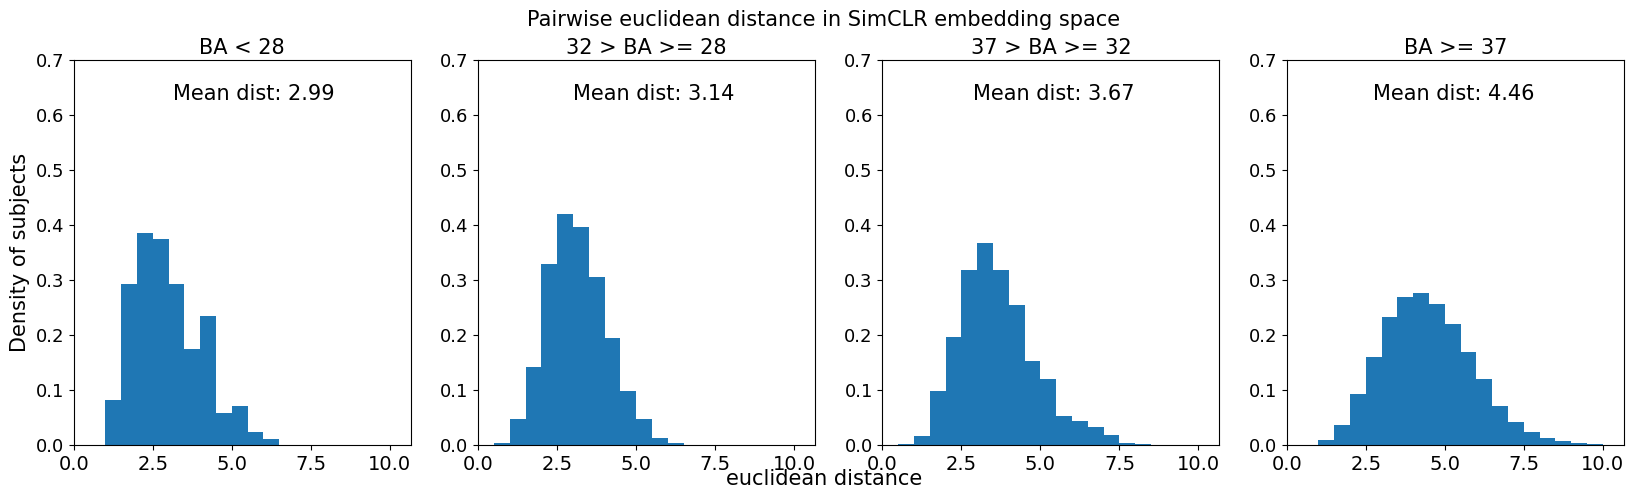

In [51]:
# normalize dims
for dim in dims:
    x = df[dim].to_numpy().reshape(-1,1)
    x = scaler.fit_transform(x)
    df[dim] = x

thresholds=[28, 32, 37]
subsample=-1
metric='euclidean'

fig, axs = plt.subplots(ncols=len(thresholds)+1, figsize=(5*(len(thresholds)+1),5))
maxi=0
for idx in range(len(thresholds)+1):
    ax = axs[idx]
    if idx==0:
        sub_df = df.loc[df['birth_age']<thresholds[0]]
        ax.set_xlabel(f'BA < {thresholds[0]}', fontsize=15)
    elif idx==len(thresholds):
        sub_df = df.loc[df['birth_age']>=thresholds[-1]]
        ax.set_xlabel(f'BA >= {thresholds[-1]}', fontsize=15)
    else:
        sub_df = df.loc[(df['birth_age']>=thresholds[idx-1]) & (df['birth_age']<thresholds[idx])]
        ax.set_xlabel(f'{thresholds[idx]} > BA >= {thresholds[idx-1]}', fontsize=15)
    ax.xaxis.set_label_position('top') 
    if subsample != -1:
        sub_df = sub_df.sample(subsample, random_state=7)
    pos_matrix = sub_df[dims].to_numpy()
    dists = pairwise_distances(pos_matrix, metric=metric)
    dists = np.tril(dists)
    dists = dists.reshape(-1,1)
    dists = list(dists[:, 0])
    dists = [d for d in dists if d!=0]
    maxi = max(np.max(dists), maxi)

    ax.hist(dists, density=True, bins=np.arange(0, maxi_hist + binwidth, binwidth))
    fig.text(0.015+0.2*(idx+1), 0.8, f'Mean dist: {np.mean(dists):.2f}', ha='center', fontsize=15)


for idx in range(len(thresholds)+1):
    axs[idx].set_xlim(0, maxi)
    axs[idx].set_ylim(0, height)
    axs[idx].tick_params(axis='x', labelsize=14)
    axs[idx].tick_params(axis='y', labelsize=13)
    if idx==0:
        axs[idx].set_ylabel('Density of subjects', fontsize=15)
plt.suptitle(f'Pairwise {metric} distance in {model} {space} space', fontsize=15)
to_keep = plt.text(x=0.5, y=0.03, s=f"{metric} distance", fontsize=15, ha="center", transform=fig.transFigure)

plt.savefig(save_dir+f'/pairwise_{metric}_distance_{model}_{space}.jpg')

plt.show()

In [52]:
#pairwise variability plot

dists_dict = {f'BA < {thresholds[0]}' :[],
        f'{thresholds[1]} > BA >= {thresholds[0]}': [],
        f'{thresholds[2]} > BA >= {thresholds[1]}': [],
        f'BA >= {thresholds[-1]}': []}

for idx in range(len(thresholds)+1):
    ax = axs[idx]
    if idx==0:
        sub_df = df.loc[df['birth_age']<thresholds[0]]
        label = f'BA < {thresholds[0]}'
    elif idx==len(thresholds):
        sub_df = df.loc[df['birth_age']>=thresholds[-1]]
        label = f'BA >= {thresholds[-1]}'
    else:
        sub_df = df.loc[(df['birth_age']>=thresholds[idx-1]) & (df['birth_age']<thresholds[idx])]
        label = f'{thresholds[idx]} > BA >= {thresholds[idx-1]}'
    ax.set_xlabel(label)
    ax.xaxis.set_label_position('top') 

    pos_matrix = sub_df[dims].to_numpy()
    dists = pairwise_distances(pos_matrix, metric=metric)
    dists = np.tril(dists)
    dists = dists.reshape(-1,1)
    dists = list(dists[:, 0])
    dists = [d for d in dists if d!=0]
    dists_dict[label].append(dists)

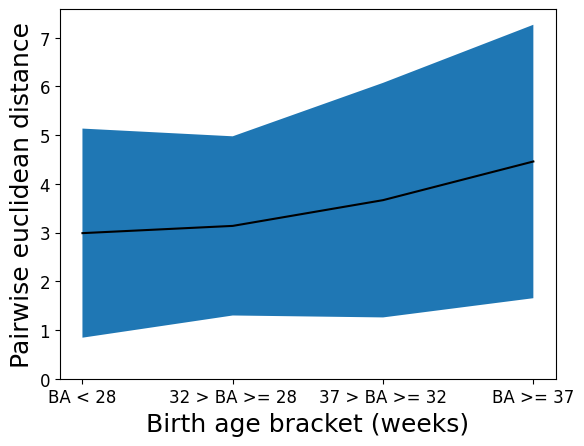

In [53]:
fig, ax = plt.subplots()

error = dists_dict.copy()
for key, value in error.items():
    err = 2*np.std(value)
    error[key]=err

dists_dict_mean = dists_dict.copy()
for key, value in dists_dict_mean.items():
    m = np.mean(value)
    dists_dict_mean[key]=m

x = dists_dict.keys()
y = np.array(list(dists_dict_mean.values()))
err = np.array(list(error.values()))

ax.plot(x, y, color='k')
ax.fill_between(x, y-err, y+err)
plt.xticks(rotation=0)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.set_ylabel(f'Pairwise {metric} distance', fontsize=18)
ax.set_xlabel('Birth age bracket (weeks)', fontsize=18)
ax.set_ylim(bottom=0)
plt.savefig(save_dir+f'/pairwise_{metric}_distance_{model}_{space}_thick_plot_v2.jpg')
plt.show()

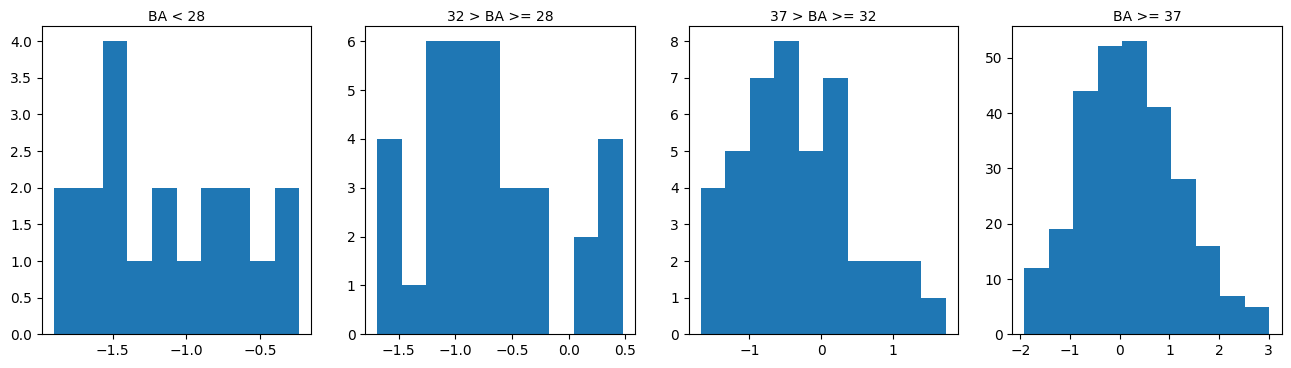

In [54]:
# perform an F-test using the distance to the center of the distribution as the distribution
# also requires to remove one degree of freedom to account for the samples dependency
# same but without subsampling and iterations

def variance(matrix):

    N,d = matrix.shape
    center = matrix.mean(axis=0).reshape(1,d)
    variance = 1/N * ((matrix - center)**2).sum()

    return(variance)

def dist_to_center(matrix):

    N,d = matrix.shape
    center = matrix.mean(axis=0).reshape(1,d)
    dists = np.linalg.norm((matrix - center), axis=1)

    return(dists)

variance_dict = {f'BA < {thresholds[0]}' :[],
        f'{thresholds[1]} > BA >= {thresholds[0]}': [],
        f'{thresholds[2]} > BA >= {thresholds[1]}': [],
        f'BA >= {thresholds[-1]}': []}

dists_to_center = variance_dict.copy()
pos_matrix_dict = variance_dict.copy()

fig, axs = plt.subplots(ncols=4, figsize=(16,4))
for idx in range(len(thresholds)+1):
    ax = axs[idx]
    if idx==0:
        sub_df = df.loc[df['birth_age']<thresholds[0]]
        label = f'BA < {thresholds[0]}'
    elif idx==len(thresholds):
        sub_df = df.loc[df['birth_age']>=thresholds[-1]]
        label = f'BA >= {thresholds[-1]}'
    else:
        sub_df = df.loc[(df['birth_age']>=thresholds[idx-1]) & (df['birth_age']<thresholds[idx])]
        label = f'{thresholds[idx]} > BA >= {thresholds[idx-1]}'
    ax.set_xlabel(label)
    ax.xaxis.set_label_position('top') 

    pos_matrix = sub_df[dims].to_numpy()
    pos_matrix_dict[label] = pos_matrix
    var = variance(pos_matrix)
    variance_dict[label] = var
    dists = dist_to_center(pos_matrix)
    dists_to_center[label] = dists
    ax.hist(pos_matrix[:,1])
plt.show()

In [55]:
# perform an F-test instead
var2 = variance_dict['BA >= 37']
nb_subjects = [19, 35, 43, 277]
df2 =nb_subjects[-1] - 1
with open(save_dir+'/pvalue.txt', 'w') as f:
    for idx, (key, value) in enumerate(variance_dict.items()):
        var1 = value
        df1 = nb_subjects[idx]-1
        F = var1/var2
        p = scipy.stats.f.cdf(F, df1, df2)
        line = f'{key}: {p}\n'
        print(line)
        f.write(line)

BA < 28: 0.021493041006439426

32 > BA >= 28: 0.0054479670295007835

37 > BA >= 32: 0.05716206726558321

BA >= 37: 0.4999999999999523

